<a href="https://colab.research.google.com/github/stellasdeutsch-dev/1dcnn/blob/main/Traffic_Flow_Prediction_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Dataset loaded. Shape: (34272, 207)
   Missing values after cleaning: 0

2. Splitting and Preprocessing (Fixing Data Leakage)...
   Train Raw Shape: (27417, 207)
   Test Raw Shape:  (6855, 207)
   Final Training Sequences: (27405, 12, 207)
   Final Testing Sequences:  (6843, 12, 207)

3. Building LSTM Model...
   Initializing Early Stopping...
   Starting training...
Epoch 1/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 0.1620 - mae: 0.2876 - val_loss: 0.0341 - val_mae: 0.1153
Epoch 2/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0382 - mae: 0.1348 - val_loss: 0.0301 - val_mae: 0.1015
Epoch 3/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0328 - mae: 0.1209 - val_loss: 0.0295 - val_mae: 0.1018
Epoch 4/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0305 - mae: 0.1151 - val_loss: 0.0283 - val_mae: 0.0954
Epoch 5/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0284 - mae: 0.1111 - val_loss: 0.0278 - val_mae: 0.0985
Epoch 6/50
429/429 ━━━━━━━━

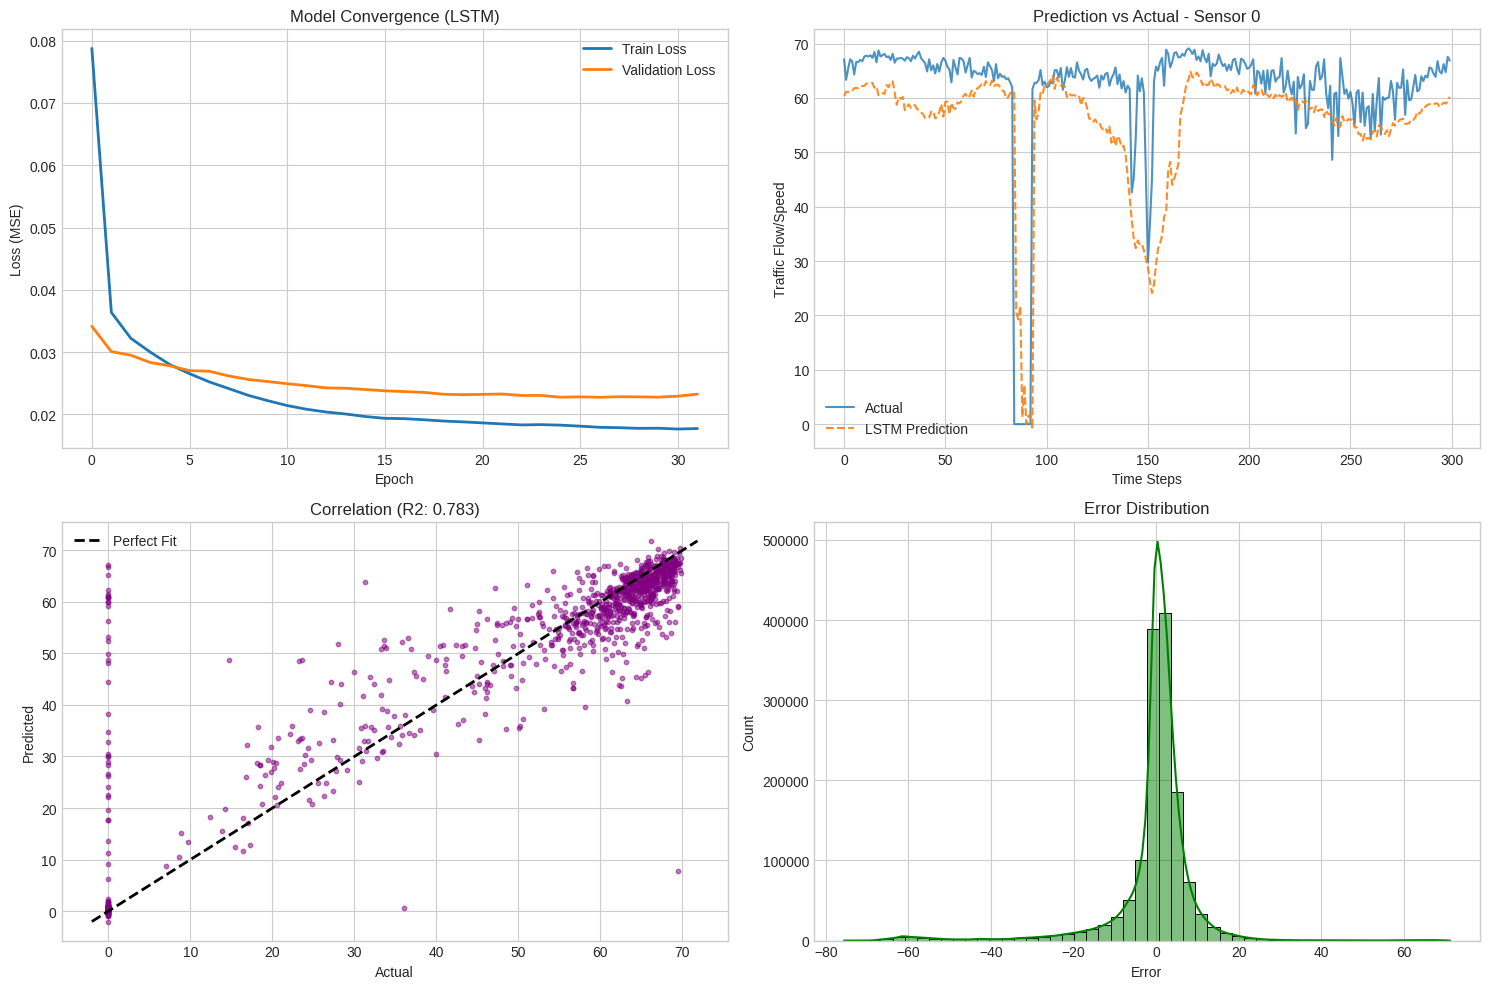

Process Complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import tensorflow as tf

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def load_data(filepath):
    """
    Loads the traffic data from CSV and handles missing values.
    """
    if not os.path.exists(filepath):
        print(f"Error: File '{filepath}' not found.")
        return None

    df = pd.read_csv(filepath, index_col=0)

    # Check if index is datetime-like
    try:
        df.index = pd.to_datetime(df.index)
    except:
        pass

    # CRITICAL FIX: Handle Missing Values
    df = df.ffill().fillna(0)

    print(f"1. Dataset loaded. Shape: {df.shape}")
    print(f"   Missing values after cleaning: {df.isnull().sum().sum()}")
    return df

def create_sequences(data, window_size, horizon=1):
    """
    Creates input sequences (X) and target values (y).
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape, output_dim):
    """
    Builds an LSTM model (Improved from CNN).
    LSTMs are designed to remember long-term dependencies in time-series data.
    """
    model = Sequential([
        Input(shape=input_shape),
        # return_sequences=True is required when stacking LSTMs
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        # Last LSTM layer usually has return_sequences=False (unless connecting to another RNN)
        LSTM(units=32, return_sequences=False),
        Dropout(0.2),
        Dense(output_dim)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def calculate_metrics(y_true, y_pred):
    """
    Calculates comprehensive performance metrics with robust MAPE.
    """
    # Safety check for NaNs in predictions
    if np.isnan(y_pred).any():
        y_pred = np.nan_to_num(y_pred)

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # IMPROVEMENT 1: Robust MAPE Calculation
    # Calculate MAPE only where actual values are > 0 to prevent Infinity
    mask = y_true > 0
    if np.sum(mask) > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = 0.0

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R2 Score": r2
    }

def main():
    # --- Configuration ---
    FILE_PATH = 'METR-LA.csv'
    WINDOW_SIZE = 12
    BATCH_SIZE = 64
    EPOCHS = 50        # Increased because we now use Early Stopping
    TRAIN_SPLIT = 0.80

    # 1. Load Data
    df = load_data(FILE_PATH)
    if df is None:
        return

    values = df.values
    num_sensors = values.shape[1]

    print("\n2. Splitting and Preprocessing (Fixing Data Leakage)...")

    # IMPROVEMENT 2: Fix Data Leakage
    # Split raw data FIRST, then fit scaler ONLY on training data
    split_idx = int(len(values) * TRAIN_SPLIT)
    train_raw = values[:split_idx]
    test_raw = values[split_idx:]

    print(f"   Train Raw Shape: {train_raw.shape}")
    print(f"   Test Raw Shape:  {test_raw.shape}")

    # Fit Scaler ONLY on Training Data
    scaler = MinMaxScaler()
    scaler.fit(train_raw)

    # Transform both sets using the training scaler
    train_scaled = scaler.transform(train_raw)
    test_scaled = scaler.transform(test_raw)

    # Create Sequences independently
    X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
    X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE)

    print(f"   Final Training Sequences: {X_train.shape}")
    print(f"   Final Testing Sequences:  {X_test.shape}")

    # 3. Build and Train Model (LSTM)
    print("\n3. Building LSTM Model...")

    # IMPROVEMENT 3: Switch to LSTM
    model = build_lstm_model(input_shape=(WINDOW_SIZE, num_sensors), output_dim=num_sensors)

    # IMPROVEMENT 4: Add Early Stopping
    print("   Initializing Early Stopping...")
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,              # Stop if no improvement for 5 epochs
        restore_best_weights=True,
        verbose=1
    )

    print("   Starting training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop], # Add callback here
        verbose=1
    )

    # 4. Prediction
    print("\n4. Generating predictions on Test Set...")
    y_pred_scaled = model.predict(X_test)

    # Inverse transform to get actual units
    y_test_actual = scaler.inverse_transform(y_test)
    y_pred_actual = scaler.inverse_transform(y_pred_scaled)

    # 5. Analytics & Table
    print("\n5. Calculating Analytics...")
    metrics = calculate_metrics(y_test_actual, y_pred_actual)
    metrics_df = pd.DataFrame([metrics])

    print("\n" + "="*40)
    print("FINAL ANALYTICS TABLE (LSTM Improved)")
    print("="*40)
    print(metrics_df.round(4).to_string(index=False))
    print("="*40 + "\n")

    # 6. Visualization
    print("6. Generating Graphs...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(15, 10))

    # Graph A: Training Loss
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Model Convergence (LSTM)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()

    # Graph B: Time Series Comparison (First Sensor)
    sensor_idx = 0
    plot_len = 300

    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(y_test_actual[:plot_len, sensor_idx], label='Actual', color='#1f77b4', alpha=0.8)
    ax2.plot(y_pred_actual[:plot_len, sensor_idx], label='LSTM Prediction', color='#ff7f0e', linestyle='--', alpha=0.9)
    ax2.set_title(f'Prediction vs Actual - Sensor {sensor_idx}')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Traffic Flow/Speed')
    ax2.legend()

    # Graph C: Scatter Plot
    sample_indices = np.random.choice(y_test_actual.flatten().shape[0], 1000, replace=False)
    y_true_sample = y_test_actual.flatten()[sample_indices]
    y_pred_sample = y_pred_actual.flatten()[sample_indices]

    ax3 = plt.subplot(2, 2, 3)
    ax3.scatter(y_true_sample, y_pred_sample, alpha=0.5, s=10, color='purple')
    min_val = min(y_true_sample.min(), y_pred_sample.min())
    max_val = max(y_true_sample.max(), y_pred_sample.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Fit')
    ax3.set_title(f'Correlation (R2: {metrics["R2 Score"]:.3f})')
    ax3.set_xlabel('Actual')
    ax3.set_ylabel('Predicted')
    ax3.legend()

    # Graph D: Error Distribution
    errors = y_test_actual - y_pred_actual

    ax4 = plt.subplot(2, 2, 4)
    # Use simple histogram if seaborn has issues, but here we use seaborn
    sns.histplot(errors.flatten(), bins=50, kde=True, ax=ax4, color='green')
    ax4.set_title('Error Distribution')
    ax4.set_xlabel('Error')

    plt.tight_layout()
    plt.show()
    print("Process Complete.")

if __name__ == "__main__":
    main()